In [1]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data"

In [2]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

## Preprocessing


In [4]:
# Separate code into two columns
new_columns = df["P_code"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["P_code_CLASS"] = new_columns[0]
df["P_code_NUM"] = new_columns[1]
df.drop(columns=["P_code"], inplace=True)

In [5]:
# P_date to datetime in day/month/year format
df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)
df.sort_values(by=["P_date"], inplace=True)
df.reset_index(drop=True, inplace=True)

C:\Users\AMAR2\AppData\Local\Temp\ipykernel_9056\3581088518.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)


In [6]:
# assert all rows in H_code follow number-number-number format
def fix_origen_typos(origen_string):
    numbers = re.findall(r"[0-9]+", origen_string)
    return "-".join(numbers)


df["H_code"] = df["H_code"].apply(fix_origen_typos)

In [7]:
# separate ORIGEN in three columns by '-'
origin_separated_columns = df["H_code"].str.split("-", expand=True)
df["PURCHASING_REGION"] = origin_separated_columns[0]
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["H_code"], inplace=True)

In [8]:
# remove /year from N_Order
# df["N_Order_PEDIDO"] = df["N_Order"].str.split("/", expand=True)[0]
# df.drop(columns=["N_Order"], inplace=True)

In [9]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
# sample random row from dataset
df.sample(1)

,P_date,N_Order,R_no,N_product_purchased,N_units,Cost,Total_product_purchase,Type_purchase,Type_logistic,PRODUCTO,P_code_CLASS,P_code_NUM,PURCHASING_REGION,PURCHASING_HOSPITAL,PURCHASING_DEPARTMENT
14168,2023-04-13,459891/23,M8275051/5,5,5,412.5,412.5,Minor purchase,TRANSIT,EQ. DE PRESION NEGATIVA / Espuma de poliuretan...,F,43580,0,11,168


In [11]:
columns = ["P_date", "Type_purchase", "N_product_purchased"]
sample_df = df[df["PURCHASING_HOSPITAL"] == "10"]
sample_df = sample_df[sample_df["P_code_NUM"] == "66071"]
sample_df = sample_df[columns]
sample_df.head()

,P_date,Type_purchase,N_product_purchased
4,2015-01-05,Minor purchase,160
63,2015-01-26,Minor purchase,160
107,2015-02-16,Minor purchase,160
139,2015-02-27,Minor purchase,160
192,2015-03-18,Minor purchase,190


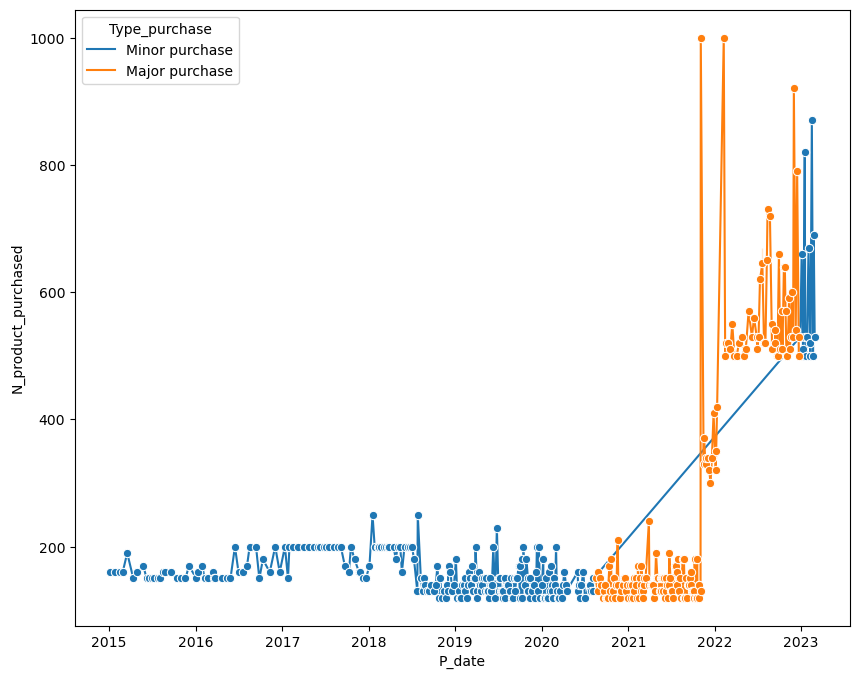

In [12]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    x="P_date", y="N_product_purchased", hue="Type_purchase", data=sample_df, marker="o"
)
plt.show()

In [13]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["P_date"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["P_date"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["P_date"].dt.day / 31)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["P_date"].dt.dayofyear / 365)
    return df


sample_df = generate_date_features(sample_df)

In [14]:
sample_df = pd.get_dummies(sample_df, columns=["Type_purchase"], prefix="Type_purchase")

In [15]:
def add_timeseries_features(df):
    df["ROLLING_MEAN_3M"] = df["N_product_purchased"].rolling(90).mean()
    df["WEIGHTED_MEAN_3M"] = (
        df["N_product_purchased"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    # df["ROLLING_MEAN_6M"] = df["N_product_purchased"].rolling(180).mean()
    # df["WEIGHTED_MEAN_6M"] = (
    #     df["N_product_purchased"]
    #     .rolling(180)
    #     .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    # )
    df["ROLLING_MEAN_1Y"] = df["N_product_purchased"].rolling(365).mean()
    df["WEIGHTED_MEAN_1Y"] = (
        df["N_product_purchased"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    return df


sample_df = add_timeseries_features(sample_df)

In [16]:
sample_df.head()

,P_date,N_product_purchased,YEAR,MONTH,DAYOFMONTH,DAYOFYEAR,Type_purchase_Major purchase,Type_purchase_Minor purchase,ROLLING_MEAN_3M,WEIGHTED_MEAN_3M,ROLLING_MEAN_1Y,WEIGHTED_MEAN_1Y
4,2015-01-05,160,2015,0.500000,0.848644,0.085965,False,True,NaN,NaN,NaN,NaN
63,2015-01-26,160,2015,0.500000,-0.848644,0.432776,False,True,NaN,NaN,NaN,NaN
107,2015-02-16,160,2015,0.866025,-0.101168,0.723644,False,True,NaN,NaN,NaN,NaN
139,2015-02-27,160,2015,0.866025,-0.724793,0.840618,False,True,NaN,NaN,NaN,NaN
192,2015-03-18,190,2015,1.000000,-0.485302,0.970064,False,True,NaN,NaN,NaN,NaN


## Baseline modelling

In [17]:
train = sample_df[sample_df["YEAR"] < 2023]
X_train = train.drop(columns=["N_product_purchased", "P_date"])
y_train = train["N_product_purchased"]

columns_for_plot = X_train.columns.tolist()

test = sample_df[sample_df["YEAR"] == 2023]
X_test = test.drop(columns=["N_product_purchased", "P_date"])
y_test = test["N_product_purchased"]

In [18]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor

# group by year
group_kfold = GroupKFold(n_splits=8)
groups = X_train["YEAR"]

# train model
model = XGBRegressor(random_state=42, n_estimators=500)

val_losses = []
test_losses = []

for idx, (train_index, test_index) in enumerate(
    group_kfold.split(X_train, y_train, groups)
):
    X_train_group, X_val_group = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_group, y_val_group = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_group, y_train_group)

    y_val_pred = model.predict(X_val_group)
    val_loss = mean_squared_error(y_val_group, y_val_pred, squared=False)
    val_losses.append(val_loss)

    y_test_pred = model.predict(X_test)
    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    test_losses.append(test_loss)

    print(
        "FOLD",
        idx,
        "| Val RMSE:",
        val_loss,
        "| Test RMSE:",
        test_loss,
        "| YEARS IN VAL:",
        X_val_group["YEAR"].unique(),
    )

print("MEAN VAL RMSE:", np.mean(val_losses))
print("MEAN TEST RMSE:", np.mean(test_losses))

FOLD 0 | Val RMSE: 112.14305619681504 | Test RMSE: 106.33040176173192 | YEARS IN VAL: [2021]
FOLD 1 | Val RMSE: 65.2005553237108 | Test RMSE: 107.84879851081422 | YEARS IN VAL: [2019]
FOLD 2 | Val RMSE: 24.093066774016357 | Test RMSE: 128.14494591955295 | YEARS IN VAL: [2020]
FOLD 3 | Val RMSE: 204.59145855127656 | Test RMSE: 252.4079614643929 | YEARS IN VAL: [2022]
FOLD 4 | Val RMSE: 225.40090257945545 | Test RMSE: 101.56672772425686 | YEARS IN VAL: [2018]
FOLD 5 | Val RMSE: 32.30638227327497 | Test RMSE: 128.05898685113166 | YEARS IN VAL: [2017]
FOLD 6 | Val RMSE: 27.106017814229965 | Test RMSE: 128.76039533301383 | YEARS IN VAL: [2016]
FOLD 7 | Val RMSE: 25.19866355597095 | Test RMSE: 126.49730985862854 | YEARS IN VAL: [2015]
MEAN VAL RMSE: 89.50501288359376
MEAN TEST RMSE: 134.95194092794037


Baseline model loss (XGBRegressor):
- Trained using GroupKFold with years as groups
- MEAN VAL RMSE: 87.12345687200653
- MEAN TEST RMSE: 104.92861512120264

In [19]:
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
print("FINAL TEST RMSE:", test_loss, "| MAPE:", mape_error)

FINAL TEST RMSE: 129.06499297577085 | MAPE: 0.11647532882206042


FINAL TEST RMSE: 83.62435512074963

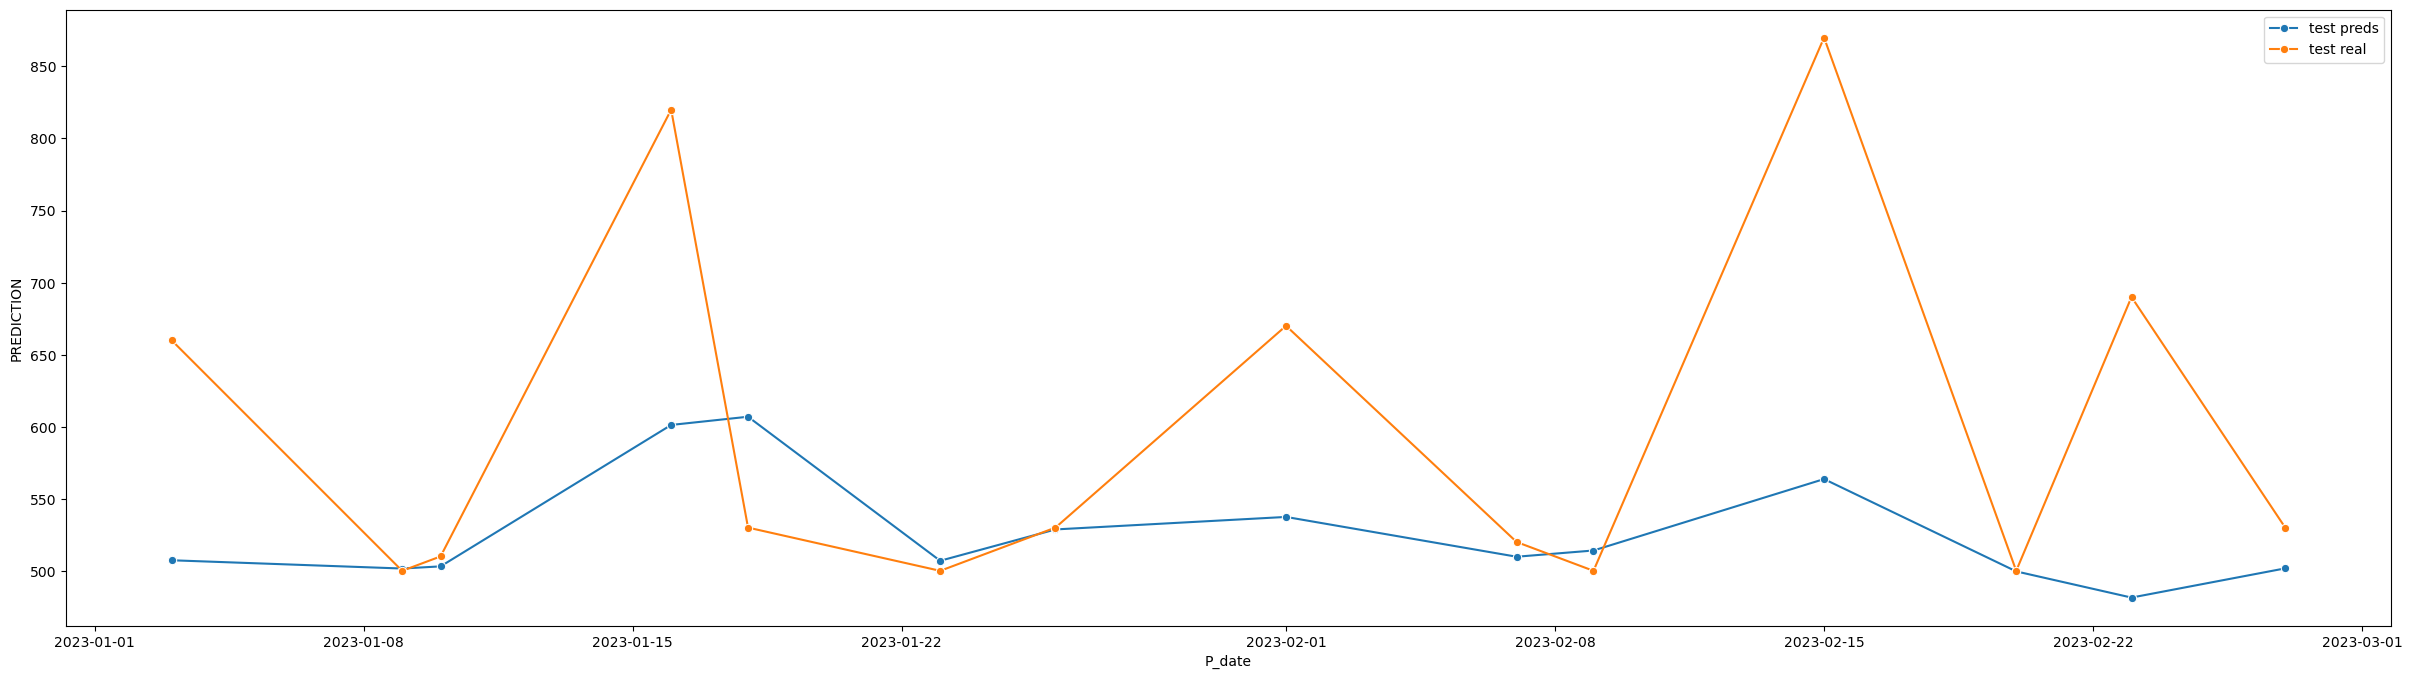

In [20]:
plt.figure(figsize=(30, 8))
X_train["PREDICTION"] = model.predict(X_train)
X_train["REAL"] = y_train
X_train["P_date"] = train["P_date"]

X_test["PREDICTION"] = y_test_pred
X_test["REAL"] = y_test
X_test["P_date"] = test["P_date"]

# sns.lineplot(
#     x="P_date", y="PREDICTION", data=X_train, marker="o", label="train preds"
# )
# sns.lineplot(x="P_date", y="REAL", data=X_train, marker="o", label="train real")
sns.lineplot(
    x="P_date", y="PREDICTION", data=X_test, marker="o", label="test preds"
)
sns.lineplot(x="P_date", y="REAL", data=X_test, marker="o", label="test real")
plt.legend()
plt.show()

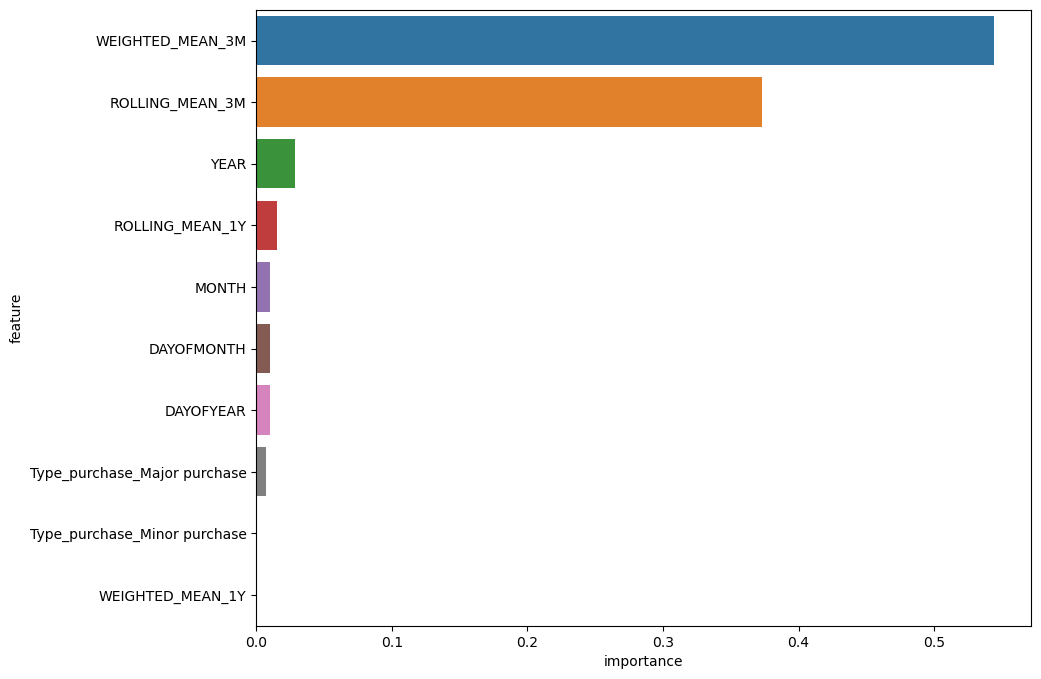

In [21]:
# model feature importance
importances = pd.DataFrame(
    {"feature": columns_for_plot, "importance": model.feature_importances_}
)
importances.sort_values(by="importance", ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=importances)
plt.show()